<a href="https://www.kaggle.com/code/loopedward/skim-literature-using-intermediate-models?scriptVersionId=138192162" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

tf.random.set_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Data Ingestion

In [2]:
TRAIN_FILE_LOCATION = '/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/train.csv'
train_dataset = pd.read_csv(TRAIN_FILE_LOCATION)

print(f"Size of training set: {len(train_dataset)}")
train_dataset.head()

Size of training set: 180040


,abstract_id,line_id,abstract_text,line_number,total_lines,target
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,OBJECTIVE
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,METHODS


In [3]:
VAL_FILE_LOCATION = '/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/dev.csv'
val_dataset = pd.read_csv(VAL_FILE_LOCATION)

print(f"Size of validation dataset: {len(val_dataset)}")
val_dataset.head()

Size of validation dataset: 30212


,abstract_id,line_id,abstract_text,line_number,total_lines,target
0,24290286,24290286_0_10,IgE sensitization to Aspergillus fumigatus and...,0,10,BACKGROUND
1,24290286,24290286_1_10,It is not clear whether these patients would b...,1,10,BACKGROUND
2,24290286,24290286_2_10,We sought to determine whether a 3-month cours...,2,10,OBJECTIVE
3,24290286,24290286_3_10,Asthmatic patients who were IgE sensitized to ...,3,10,METHODS
4,24290286,24290286_4_10,Primary outcomes were improvement in quality o...,4,10,METHODS


In [4]:
TEST_FILE_LOCATION = '/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/test.csv'
test_dataset = pd.read_csv(TEST_FILE_LOCATION)

print(f"Size of test dataset: {len(test_dataset)}")
test_dataset.head()

Size of test dataset: 30135


,abstract_id,line_id,abstract_text,line_number,total_lines,target
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,BACKGROUND
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,RESULTS
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,RESULTS
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,RESULTS
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,RESULTS


# Preprocessing the datasets

## 1. Encoding the classes

In [5]:
from sklearn.preprocessing import LabelEncoder

y_encoder = LabelEncoder()
y_encoder.fit(train_dataset['target'])
CLASSES = y_encoder.classes_
CLASSES

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [6]:
y_train = y_encoder.transform(train_dataset['target'])
y_train

array([3, 2, 2, ..., 4, 1, 1])

In [7]:
y_val = y_encoder.transform(val_dataset['target'])
y_val

array([0, 0, 3, ..., 4, 1, 1])

In [8]:
y_test = y_encoder.transform(test_dataset['target'])
y_test

array([0, 4, 4, ..., 4, 4, 1])

## 2. Extract the text as features

In [9]:
from tensorflow.data import Dataset, AUTOTUNE

BATCH_SIZE = 256

def batch_dataset(X, y):
    return Dataset.from_tensor_slices((X['abstract_text'], y)) \
        .batch(BATCH_SIZE) \
        .prefetch(AUTOTUNE)

train_df = batch_dataset(train_dataset, y_train)
len(train_df), train_df

(704,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [10]:
val_df = batch_dataset(val_dataset, y_val)
len(val_df), val_df

(119,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [11]:
test_df = batch_dataset(test_dataset, y_test)
len(test_df), test_df

(118,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Model 1: USE

In [12]:
from tensorflow_hub import KerasLayer
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

TF_USE_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'

def build_model_1():
    inputs = Input(shape=[], dtype=tf.string)
    encoder = KerasLayer(TF_USE_URL, name='USE', trainable=False)(inputs)
    outputs = Dense(len(CLASSES), activation='softmax')(encoder)
    
    return Model(inputs, outputs)

In [13]:
model_1 = build_model_1()
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 256,800,389
Trainable params: 2,565
Non-trainable params: 256,797,824
_________________________________________________________________


In [14]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model_1.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy']
)

model_1_history = model_1.fit(train_df,
                             epochs=3,
                             validation_data=val_df)

Epoch 1/3
704/704 [==============================] - 40s 45ms/step - loss: 1.1098 - accuracy: 0.6022 - val_loss: 0.9114 - val_accuracy: 0.6728
Epoch 2/3
704/704 [==============================] - 33s 46ms/step - loss: 0.8585 - accuracy: 0.6866 - val_loss: 0.8144 - val_accuracy: 0.7005
Epoch 3/3
704/704 [==============================] - 31s 45ms/step - loss: 0.8002 - accuracy: 0.7021 - val_loss: 0.7800 - val_accuracy: 0.7096


<Axes: >

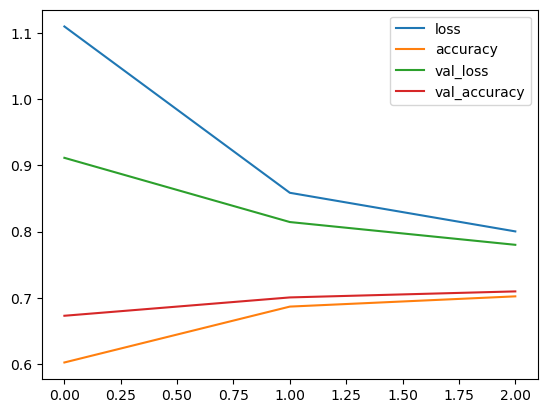

In [15]:
pd.DataFrame(model_1_history.history).plot()

## Model 2: Character-Level Vectorization

## The Char Vectorizer

array([[<Axes: title={'center': '0'}>]], dtype=object)

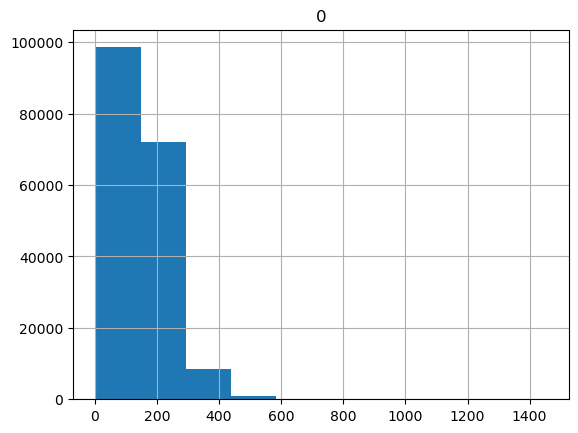

In [16]:
char_lengths = [len(sentence) for sentence in train_dataset['abstract_text']]
pd.DataFrame(char_lengths).hist()

In [17]:
np.percentile(char_lengths, 95)

296.0

In [18]:
CHAR_SEQUENCE_OUTPUT_LENGTH = 300

In [19]:
import string

alphabet = string.ascii_lowercase + string.digits
len(alphabet), alphabet

(36, 'abcdefghijklmnopqrstuvwxyz0123456789')

In [20]:
from tensorflow.keras.layers import TextVectorization

def build_char_vectorizer():
    vectorizer = TextVectorization(
        max_tokens=len(alphabet) + 2, # for space + <OOV>
        split='character',
        output_sequence_length=CHAR_SEQUENCE_OUTPUT_LENGTH,
        name='character_vectorizer',
    )
    vectorizer.adapt(train_dataset['abstract_text'])
    return vectorizer

char_vectorizer = build_char_vectorizer()

In [21]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Length of vocabulary: {len(char_vocab)}")

Length of vocabulary: 38


In [22]:
print(f"5 most common words: {char_vocab[:5]}")
print(f"5 least common words: {char_vocab[-5:]}")

5 most common words: ['', '[UNK]', ' ', 'e', 't']
5 least common words: ['9', '8', '7', 'z', 'q']


In [23]:
sample_sentence = train_dataset['abstract_text'][5]
print(f"Sample sentence: {sample_sentence}")
print(f"Vectorized version: {char_vectorizer([sample_sentence])}")

Sample sentence: Serum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .
Vectorized version: [[10  3  9 17 16  2 13  3 22  3 13 10  2  8 18  2  5  7  4  3  9 13  3 17
  28  5  7  2 25  2  2  5 13 25  2  2  2  5 13 32  2  2  4 17 16  8  9  2
   7  3 12  9  8 10  5 10  2 18  6 12  4  8  9  2  2  4  7 18  2  2  2  2
   6  7 11  2 14  5 19 14 10  3  7 10  5  4  5 22  5  4 20  2 12  9  3  6
  12  4  5 22  3  2 15  9  8  4  3  5  7  2  2 14 10 12  9 15  2  2 21  3
   9  3  2 16  3  6 10 17  9  3 11  2  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 

## The Character-Level Embedding

In [24]:
from tensorflow.keras.layers import Embedding

CHAR_EMBEDDING_DIMENSION=25

def make_char_embedding():
    return Embedding(
        input_dim=len(char_vocab),
        output_dim=CHAR_EMBEDDING_DIMENSION,
        input_length=CHAR_SEQUENCE_OUTPUT_LENGTH,
        mask_zero=True
    )

In [25]:
char_embedding = make_char_embedding()

sample_embedded = char_embedding(char_vectorizer(sample_sentence))
sample_embedded.shape, sample_embedded

(TensorShape([300, 25]),
 <tf.Tensor: shape=(300, 25), dtype=float32, numpy=
 array([[ 4.8300151e-02,  7.0752986e-03, -1.2605857e-02, ...,
          2.3095820e-02, -4.2419817e-02,  2.4377193e-02],
        [ 4.1256692e-02, -1.3531826e-02, -1.5833862e-03, ...,
          1.9448783e-02,  2.9423181e-02, -4.9072020e-03],
        [-1.6567595e-03, -1.6768228e-02,  1.7181039e-03, ...,
          4.3139968e-02, -4.5372691e-02, -3.9787401e-02],
        ...,
        [ 3.3174697e-02, -3.1785093e-02, -4.6005394e-02, ...,
         -3.2637693e-02,  3.9962914e-02,  2.6024878e-05],
        [ 3.3174697e-02, -3.1785093e-02, -4.6005394e-02, ...,
         -3.2637693e-02,  3.9962914e-02,  2.6024878e-05],
        [ 3.3174697e-02, -3.1785093e-02, -4.6005394e-02, ...,
         -3.2637693e-02,  3.9962914e-02,  2.6024878e-05]], dtype=float32)>)

### The Model

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense

def build_model_2():
    return Sequential([
        Input(shape=(1,), dtype=tf.string),
        char_vectorizer,
        make_char_embedding(),
        Conv1D(64, 30, activation='relu'),
        GlobalMaxPooling1D(),
#         GlobalAveragePooling1D(),
        Dense(len(CLASSES), activation='softmax')
    ])

model_2 = build_model_2()
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 character_vectorizer (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 300, 25)           950       
                                                                 
 conv1d (Conv1D)             (None, 271, 64)           48064     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 49,339
Trainable params: 49,339
Non-traina

In [27]:
model_2.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy']
)

model_2_history = model_2.fit(train_df,
                              epochs=3,
                              validation_data=val_df)

Epoch 1/3
704/704 [==============================] - 22s 22ms/step - loss: 0.9087 - accuracy: 0.6411 - val_loss: 0.6868 - val_accuracy: 0.7406
Epoch 2/3
704/704 [==============================] - 15s 21ms/step - loss: 0.6427 - accuracy: 0.7597 - val_loss: 0.6166 - val_accuracy: 0.7712
Epoch 3/3
704/704 [==============================] - 15s 22ms/step - loss: 0.5838 - accuracy: 0.7825 - val_loss: 0.5947 - val_accuracy: 0.7792


<Axes: >

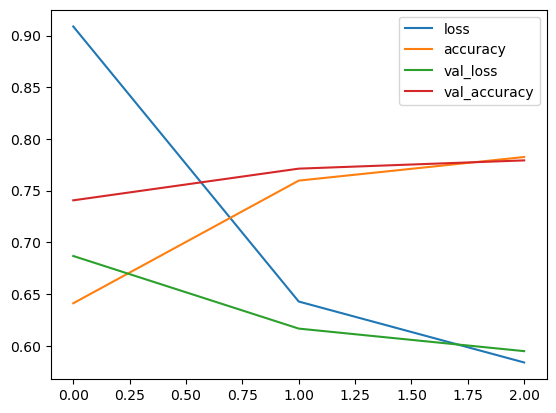

In [28]:
pd.DataFrame(model_2_history.history).plot()

# Model 3: USE (Token-Level) + Character-Level Multi-input Model

In [29]:
from tensorflow.keras.layers import Concatenate

def build_model_3():
    token_model = build_model_1()
    char_model = build_model_2()
    
    concat_model = Concatenate()([token_model.output, char_model.output])
    dense_layer = Dense(128)(concat_model)
    output_model = Dense(len(CLASSES), activation='softmax')(dense_layer)
    
    return Model((token_model.input, char_model.input), output_model)

model_3 = build_model_3()
model_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 300)         0           ['input_4[0][0]']                
 orization)                                                                                       
                                                                                                  
 embedding_2 (Embedding)        (None, 300, 25)      950         ['character_vectorizer[1][0]']   
                                                                                                  
 input_3 (InputLayer)           [(None,)]            0           []                         

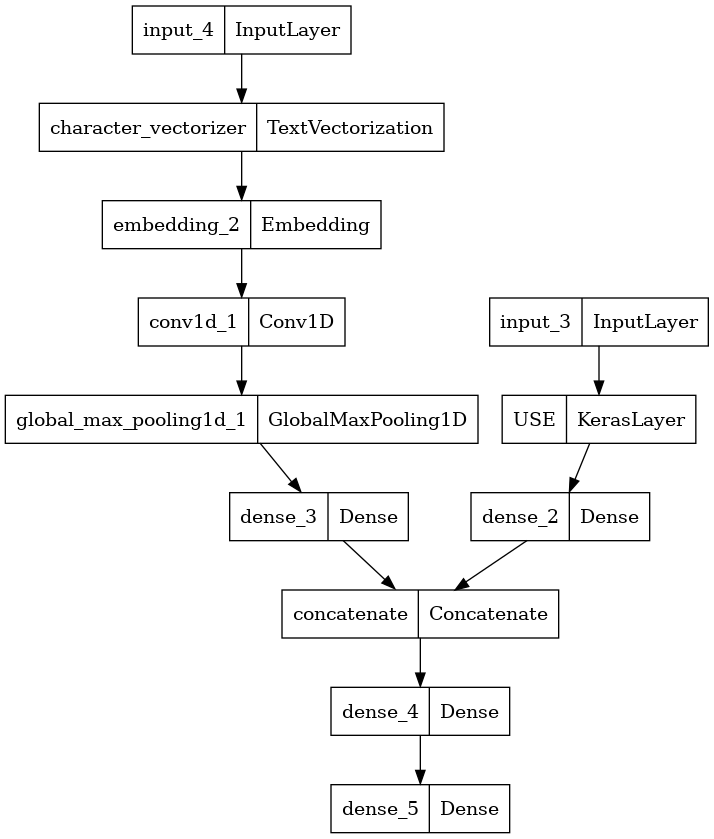

In [30]:
from tensorflow.keras.utils import plot_model

plot_model(model_3)

In [31]:
model_3_X_train = Dataset.from_tensor_slices((train_dataset['abstract_text'], train_dataset['abstract_text']))
model_3_y_train = Dataset.from_tensor_slices(y_train)
model_3_train_dataset = Dataset.zip((model_3_X_train, model_3_y_train)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

model_3_train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
model_3_X_val = Dataset.from_tensor_slices((val_dataset['abstract_text'], val_dataset['abstract_text']))
model_3_y_val = Dataset.from_tensor_slices(y_val)
model_3_val_dataset = Dataset.zip((model_3_X_val, model_3_y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

model_3_val_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [33]:
model_3.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy']
)

model_3_history = model_3.fit(model_3_train_dataset, 
                              epochs=3,
                              validation_data=model_3_val_dataset
                             )

Epoch 1/3
704/704 [==============================] - 53s 68ms/step - loss: 0.8808 - accuracy: 0.6385 - val_loss: 0.6631 - val_accuracy: 0.7282
Epoch 2/3
704/704 [==============================] - 47s 67ms/step - loss: 0.6168 - accuracy: 0.7649 - val_loss: 0.5842 - val_accuracy: 0.7822
Epoch 3/3
704/704 [==============================] - 47s 67ms/step - loss: 0.5493 - accuracy: 0.7966 - val_loss: 0.5685 - val_accuracy: 0.7912


<Axes: >

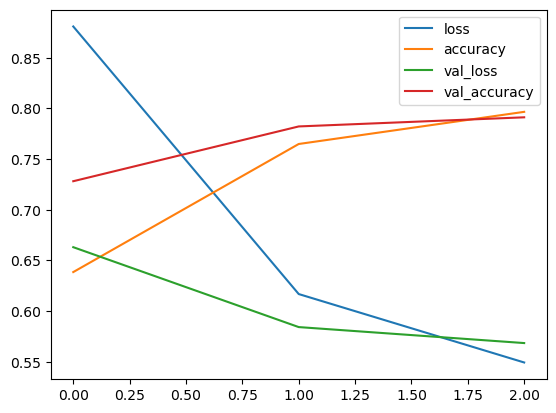

In [34]:
pd.DataFrame(model_3_history.history).plot()

In [35]:
# SAVE ME TO GITHUB FIRST!

In [36]:
train_dataset.head(15)

,abstract_id,line_id,abstract_text,line_number,total_lines,target
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,OBJECTIVE
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,METHODS
5,24293578,24293578_5_12,"Serum levels of interleukin 1 ( IL-1 ) , IL-6 ...",5,12,METHODS
6,24293578,24293578_6_12,There was a clinically relevant reduction in t...,6,12,RESULTS
7,24293578,24293578_7_12,The mean difference between treatment arms ( 9...,7,12,RESULTS
8,24293578,24293578_8_12,"Further , there was a clinically relevant redu...",8,12,RESULTS
9,24293578,24293578_9_12,These differences remained significant at 12 w...,9,12,RESULTS
